In [283]:
 # ----------- Overhead -------------

import pandas as pd
import numpy as np
# import scipy.stat as sps
import matplotlib.pyplot as plt
import seaborn as sns
# from pandas import ExcelWriter
from sklearn import preprocessing
from sklearn.decomposition import PCA
from keras.models import Model
from keras.layers import Input, Dense
import numpy as np

## Fix roger's stuff
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'


In [284]:
df = pd.read_csv('NY property csv.csv')

In [285]:
# --------------- Fill in NAs and 0s ----------

# Create new variable BORO
df['BORO'] = ''
df['BORO'] = df.BBLE.str[0]

# ZIP, sort by BBLE and forward fill
df = df.sort_values(by = ['BBLE'])
df['ZIP'].fillna(method='ffill',inplace = True)

# Create ZIP3
df['ZIP3']= df["ZIP"].apply(lambda x: int(str(x)[0:3]))


df['ll_rate'] = df['LTFRONT']/df['LTDEPTH']
mean_llrate = np.mean(df['ll_rate'].dropna())
df['LTFRONT'] = df['LTFRONT'].fillna(value = (df['LTDEPTH'] * mean_llrate))
df['LTFRONT'] = df['LTDEPTH'].fillna(value = (df['LTFRONT'] / mean_llrate))
np.std(df['LTFRONT'])
# std = 73.7 without group
# two methods to set 0 values as missing values
df.loc[df['LTFRONT'] == 0, 'LTFRONT'] = np.nan
# df['LTFRONT'] = df['LTFRONT'].replace(0,np.nan)

# fill NA with average values grouped by BORO (if using TAXCLASS as well, 
# the filled values will be too big and there will be 2 missing values)
df['LTFRONT'] = df.groupby(['BORO','TAXCLASS'])['LTFRONT'].transform(lambda x: x.fillna(x.mean()))
df['LTFRONT'] = df.groupby(['TAXCLASS'])['LTFRONT'].transform(lambda x: x.fillna(x.mean()))


df.loc[df['LTDEPTH'] == 0, 'LTDEPTH'] = np.nan
df['LTDEPTH'] = df.groupby(['BORO','TAXCLASS'])['LTDEPTH'].transform(lambda x: x.fillna(x.mean()))
df['LTDEPTH'] = df.groupby(['TAXCLASS'])['LTDEPTH'].transform(lambda x: x.fillna(x.mean()))

# np.isnan(df['LTDEPTH']).sum()

# Calculate BLDFRONT/BLDDEPTH ratio
df.loc[df['BLDFRONT'] == 0, 'BLDFRONT'] = np.nan
df.loc[df['BLDDEPTH'] == 0, 'BLDDEPTH'] = np.nan

df['bb_rate'] = df['BLDFRONT']/df['BLDDEPTH']
# distribution of the ratio
# sns.distplot(df['BLDFRONT']/df['BLDDEPTH'].dropna(), bins = 1000,kde=False)
# plt.xlim(0,2)

median_bbrate = np.median(df['bb_rate'].dropna())
df['BLDFRONT'] = df['BLDFRONT'].fillna(value = (df['BLDDEPTH'] * median_bbrate))
df['BLDDEPTH'] = df['BLDDEPTH'].fillna(value = (df['BLDFRONT'] / median_bbrate))


# For BLDFRONT and BLDDEPTH, if group by both BORO and TAXCLASS, there will appear NaN as well.
df['BLDFRONT'] = df.groupby(['BORO','TAXCLASS'])['BLDFRONT'].transform(lambda x: x.fillna(x.mean()))
df['BLDFRONT'] = df.groupby(['TAXCLASS'])['BLDFRONT'].transform(lambda x: x.fillna(x.mean()))

# np.isnan(df['BLDFRONT']).sum()
df['BLDDEPTH'] = df.groupby(['BORO','TAXCLASS'])['BLDDEPTH'].transform(lambda x: x.fillna(x.mean()))
df['BLDDEPTH'] = df.groupby(['TAXCLASS'])['BLDDEPTH'].transform(lambda x: x.fillna(x.mean()))

np.isnan(df['BLDFRONT']).sum()
np.isnan(df['BLDDEPTH']).sum()

df['STORIES'] = df.groupby(['ZIP','TAXCLASS'])['STORIES'].transform(lambda x: x.fillna(x.mean()))
df['STORIES'] = df.groupby(['TAXCLASS'])['STORIES'].transform(lambda x: x.fillna(x.mean()))

# np.isnan(df['STORIES']).sum()

# building volume and bins accordingly
df['bldvol'] = df['BLDFRONT'] * df['BLDDEPTH'] * df['STORIES']

df['bldvol_bin'] = pd.qcut(df['bldvol'], 100, labels = False, duplicates = 'drop')

# FULLVAL
df.loc[df['FULLVAL'] == 0, 'FULLVAL'] = np.nan

# df['FULLVAL']
df['FULLVAL'] = df.groupby(['BORO','bldvol_bin'])['FULLVAL'].transform(lambda x: x.fillna(x.mean()))
# np.isnan(df['FULLVAL']).sum()


# AVLAND
df.loc[df['AVLAND'] == 0, 'AVLAND'] = np.nan
df['AVLAND'] = df.groupby(['BORO','bldvol_bin'])['AVLAND'].transform(lambda x: x.fillna(x.mean()))
# np.isnan(df['AVLAND']).sum()


# AVTOT
df.loc[df['AVTOT'] == 0, 'AVTOT'] = np.nan
df['AVTOT'] = df.groupby(['BORO','bldvol_bin'])['AVTOT'].transform(lambda x: x.fillna(x.mean()))
# np.isnan(df['AVTOT']).sum()

In [286]:
## Build 3 sizes
## Build LotArea, Building Area, Building Volume
df['lotarea'] = df['LTDEPTH'] * df['LTFRONT']
df['bldarea'] = df['BLDFRONT'] * df['BLDDEPTH']
df['bldvol'] = df['bldarea'] * df['STORIES']

## Build 9 values
## FV = FULLVAL, AL = AVLAND, AT = AVTOT
## LA = LOTAREA, BA = BLDAREA, BV = BLDVOL
df['fv_la'] = df['FULLVAL'] / df['lotarea']
df['fv_ba'] = df['FULLVAL'] / df['bldarea']
df['fv_bv'] = df['FULLVAL'] / df['bldvol']
df['al_la'] = df['AVLAND'] / df['lotarea']
df['al_ba'] = df['AVLAND'] / df['bldarea']
df['al_bv'] = df['AVLAND'] / df['bldvol']
df['at_la'] = df['AVTOT'] / df['lotarea']
df['at_ba'] = df['AVTOT'] / df['bldarea']
df['at_bv'] = df['AVTOT'] / df['bldvol']

## Build 45 Group by values



In [287]:
ninevars = ['fv_la','fv_ba','fv_bv','al_la','al_ba','al_bv','at_la','at_ba','at_bv']
df = df.join(df.groupby(['ZIP'])[ninevars].mean(), on='ZIP', rsuffix='_zip')
df = df.join(df.groupby(['ZIP3'])[ninevars].mean(), on='ZIP3', rsuffix='_zip3')
df = df.join(df.groupby(['TAXCLASS'])[ninevars].mean(), on='TAXCLASS', rsuffix='_taxclass')
df = df.join(df.groupby(['BORO'])[ninevars].mean(), on='BORO', rsuffix='_boro')
# add stories bins
df['story_bin'] = pd.qcut(df['STORIES'], 10, labels=False, duplicates = 'drop')
df = df.join(df.groupby(['story_bin'])[ninevars].mean(), on='story_bin', rsuffix='_story')
df = df.join(df.groupby(['BORO','TAXCLASS'])[ninevars].mean(), on=['BORO','TAXCLASS'], rsuffix='_BoroTax')


In [288]:
newdf = df[['fv_la',
 'fv_ba',
 'fv_bv',
 'al_la',
 'al_ba',
 'al_bv',
 'at_la',
 'at_ba',
 'at_bv',
 'fv_la_zip',
 'fv_ba_zip',
 'fv_bv_zip',
 'al_la_zip',
 'al_ba_zip',
 'al_bv_zip',
 'at_la_zip',
 'at_ba_zip',
 'at_bv_zip',
 'fv_la_zip3',
 'fv_ba_zip3',
 'fv_bv_zip3',
 'al_la_zip3',
 'al_ba_zip3',
 'al_bv_zip3',
 'at_la_zip3',
 'at_ba_zip3',
 'at_bv_zip3',
 'fv_la_taxclass',
 'fv_ba_taxclass',
 'fv_bv_taxclass',
 'al_la_taxclass',
 'al_ba_taxclass',
 'al_bv_taxclass',
 'at_la_taxclass',
 'at_ba_taxclass',
 'at_bv_taxclass',
 'fv_la_boro',
 'fv_ba_boro',
 'fv_bv_boro',
 'al_la_boro',
 'al_ba_boro',
 'al_bv_boro',
 'at_la_boro',
 'at_ba_boro',
 'at_bv_boro',
 'fv_la_story',
 'fv_ba_story',
 'fv_bv_story',
 'al_la_story',
 'al_ba_story',
 'al_bv_story',
 'at_la_story',
 'at_ba_story',
 'at_bv_story',
 'fv_la_BoroTax',
 'fv_ba_BoroTax',
 'fv_bv_BoroTax',
 'al_la_BoroTax',
 'al_ba_BoroTax',
 'al_bv_BoroTax',
 'at_la_BoroTax',
 'at_ba_BoroTax',
 'at_bv_BoroTax']]

# newdf.head()

In [289]:
# ---- Z scale to prepare for dimensionality reduction ----
# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
scaled_df = scaler.fit_transform(newdf)
scaled_df = pd.DataFrame(scaled_df, columns=list(newdf))
# scaled_df.head()
scaled_df.mean(axis = 0)


fv_la             1.068234e-16
fv_ba             1.904852e-16
fv_bv            -3.079365e-16
al_la             2.379177e-16
al_ba             6.265363e-17
al_bv             9.151735e-17
at_la            -1.267877e-16
at_ba            -2.480789e-16
at_bv            -6.004325e-17
fv_la_zip         3.174745e-13
fv_ba_zip         4.593361e-13
fv_bv_zip        -6.953283e-13
al_la_zip        -1.797883e-13
al_ba_zip        -2.217321e-15
al_bv_zip        -1.356566e-13
at_la_zip         2.322877e-13
at_ba_zip        -1.690775e-13
at_bv_zip         3.188577e-14
fv_la_zip3       -1.486256e-12
fv_ba_zip3        3.348692e-12
fv_bv_zip3       -7.630473e-12
al_la_zip3        6.273916e-12
al_ba_zip3        1.153986e-12
al_bv_zip3       -1.442909e-12
at_la_zip3        3.156365e-12
at_ba_zip3       -5.266331e-13
at_bv_zip3       -1.362721e-12
fv_la_taxclass   -4.750108e-13
fv_ba_taxclass    2.787829e-12
fv_bv_taxclass    1.807583e-12
                      ...     
at_la_taxclass   -2.293578e-12
at_ba_ta

In [290]:
#mean(newdf['fv_la'])

(0, 1)

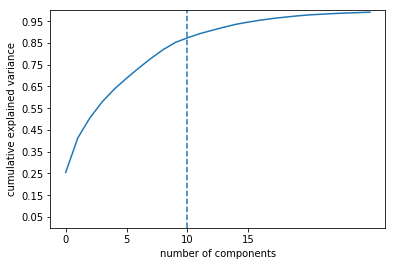

In [291]:
pca = PCA(n_components = 0.99, svd_solver = 'full')
pca.fit(scaled_df)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.yticks(np.arange(0.05, 1.1, step=0.1))
plt.xticks(np.arange(0, 20, step=5))
# plt.axhline(y=0.85,  linestyle='--')
plt.axvline(x= 10 ,  linestyle='--')
plt.ylim(0,1)

In [292]:
# ---- PCA: reduce dimensions ----
pca = PCA(n_components = .85, svd_solver = 'full')
pca.fit(scaled_df)
pca.n_components_

10

In [293]:
# Percentage of variance explained by each of the selected components.
print(np.cumsum(pca.explained_variance_ratio_))

[0.25435587 0.41372482 0.50630309 0.57924094 0.6379599  0.68784081
 0.73454583 0.77879508 0.81908364 0.85231235]


In [294]:
# transformed dataframe
pca_df = pd.DataFrame(data = pca.transform(scaled_df), columns =  ["PC" + str(i) for i in range(1, pca.n_components_+1)])

In [295]:
# ---- Z scale to PCA dataframe ----

scaled_pca = scaler.fit_transform(pca_df)
scaled_pca = pd.DataFrame(scaled_pca, columns=list(pca_df))
# scaled_pca.head()
# scaled_pca.std(axis = 0)


In [296]:
## Convert df to ndarray
matrix_pca = scaled_pca.values

In [297]:
## Autoencoder
# def simple_auto_encode(input_matrix, compression_factor=1.1, encode_activation='tanh', decode_activation='linear',
#                        optimizer='Adadelta', loss='mean_squared_error'):
#     _, input_dim = matrix_pca.shape
#     encoding_dim = int(input_dim // compression_factor)

#     input_layer = Input(shape=(input_dim,))
#     encode_layer = Dense(encoding_dim, activation=encode_activation)(input_layer)
#     decode_layer = Dense(input_dim, activation=decode_activation)(encode_layer)

#     auto_encoder = Model(input_layer, decode_layer)
#     auto_encoder.compile(optimizer=optimizer, loss=loss)
#     auto_encoder.fit(input_matrix, input_matrix, epochs=10, batch_size=1)

#     return auto_encoder.predict(input_matrix)

# matrix_reproduce = simple_auto_encode(matrix_pca)

In [298]:
matrix_reproduce = np.loadtxt('reproduce.txt', dtype='float32')

In [299]:
mse = ((matrix_pca - matrix_reproduce)**2).mean(axis=1)

In [300]:
mse.max()

55261.93257888302

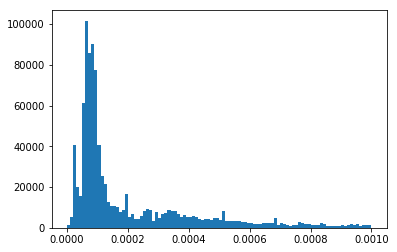

In [301]:
plt.hist(mse, bins=100, range=(0,0.001))
plt.show()
## Mse has the most ideal distribution. Therefore we use mse as fraud score 2.

In [302]:
mse.max()

55261.93257888302

In [303]:
measurement = (((matrix_pca - matrix_reproduce)**2).sum(axis=1))**0.5

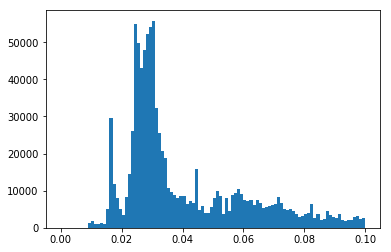

In [304]:
plt.hist(measurement, bins=100, range=(0,0.1))
plt.show()

In [305]:
scaled_pca["mae"] = (matrix_pca - matrix_reproduce).mean(axis=1)
scaled_pca["MAHAL"]=(scaled_pca["PC1"]**2+scaled_pca["PC2"]**2+scaled_pca["PC3"]**2+scaled_pca["PC4"]**2+scaled_pca["PC5"]**2+scaled_pca["PC6"]**2+scaled_pca["PC7"]**2+scaled_pca["PC8"]**2+scaled_pca["PC9"]**2+scaled_pca["PC10"]**2)**0.5

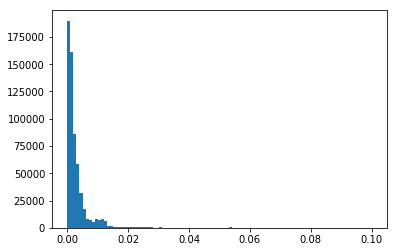

In [306]:
plt.hist(scaled_pca["mae"], bins=100, range=(0,0.1))
plt.show()

In [307]:
## Create 3 measures
scaled_pca["mse"] = ((matrix_pca - matrix_reproduce)**2).mean(axis=1)
scaled_pca["measurement"] = (((matrix_pca - matrix_reproduce)**2).sum(axis=1))**0.5
scaled_pca["MAHAL"]=(scaled_pca["PC1"]**2+scaled_pca["PC2"]**2+scaled_pca["PC3"]**2+scaled_pca["PC4"]**2+scaled_pca["PC5"]**2+scaled_pca["PC6"]**2+scaled_pca["PC7"]**2+scaled_pca["PC8"]**2+scaled_pca["PC9"]**2+scaled_pca["PC10"]**2)**0.5

## Create 3 ranks and Combined rank
scaled_pca["MahalRank"] = scaled_pca["MAHAL"].rank()
scaled_pca["MeasurementRank"] = scaled_pca["measurement"].rank()
scaled_pca["CombRank"] = (scaled_pca["MahalRank"]+scaled_pca["MeasurementRank"])/2
sorted_comb = scaled_pca.sort_values("CombRank",ascending=False)
sorted_comb[0:10]

## Get top 10
sorted_comb[0:10].index

#df.iloc[632816]
#df.iloc[sorted_comb[0:10].index]

Int64Index([632816, 126404, 126399, 138829, 585118, 108896, 85886, 918305,
            934793, 934780],
           dtype='int64')

In [345]:
top_ten = sorted_comb[0:10].index
df[df.index.isin(top_ten)]
scaled_pca.loc[376242]

PC1                    -0.718701
PC2                     0.076304
PC3                    -0.504719
PC4                     0.033340
PC5                    -0.495589
PC6                     0.250080
PC7                    -0.166077
PC8                     0.070753
PC9                    -0.068338
PC10                   -0.261261
mae                     0.004072
MAHAL                   1.091728
mse                     0.000060
measurement             0.024462
MahalRank          116538.000000
MeasurementRank    141649.000000
CombRank           129093.500000
Name: 376242, dtype: float64

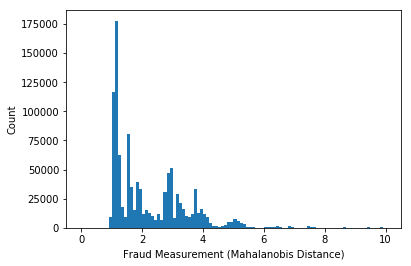

In [350]:
plt.hist(scaled_pca["MAHAL"], bins=100, range=(0,10))
plt.xlabel('Fraud Measurement (Mahalanobis Distance)')
plt.ylabel('Count')
plt.show()

In [351]:
sorted_comb[0:10].to_csv('rank.csv')